# Homework 4: Predictive Process Monitoring

This task uses the Turnaround process event log that we used in Practice 8 of the course. The link has been provided in Slack (Event log link: http://kodu.ut.ee/~chavez85/pm_course/data/turnaround_anon_sla.csv)

This goal of this homework is to train and use predictive process monitoring techniques to predict the outcome of a process from a log of events. Make the necessary modifications to the framework proposed by Taineema et al. reviewed in class to meet this goal (framework link: https://github.com/Mcamargo85/predictive-monitoring-benchmark.git).

### Notes
All of the code can be found in this notebook (including the ngram generation method).

Homework repository: https://github.com/antialman/predictive-monitoring-benchmark

## Task 1

(1 point) As part of the log preprocessing, it is necessary to categorize the process traces as deviant or regular. This log contains a column called SLA. it is a "case attribute," which indicates how many minutes each case must complete. 

You must create a new column in the log that contains a case attribute called _label_, which contains a value of 1 for deviant cases or 0 for regular ones. This column's value is 0 if the duration of the case (in minutes) is less than or equal to the SLA; otherwise, this column's value must be 1 (the SLA has not been met). 

NB! If there are cases that do not have SLA, categorize them as 0.

In [1]:
##Imports
import pandas as pd
import math
from nltk import ngrams
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
##Loading the event log
file_path = 'hw_input/turnaround_anon_sla.csv'
df = pd.read_csv(file_path)
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0


In [3]:
##Checking the initial datatypes
df.dtypes

caseid              object
activity            object
start_timestamp     object
end_timestamp       object
SLA MIN            float64
dtype: object

In [4]:
##Fixing data types of timestamp columns
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='%Y-%m-%d %H:%M:%S')
df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format='%Y-%m-%d %H:%M:%S')
#df.head()
df.dtypes

caseid                     object
activity                   object
start_timestamp    datetime64[ns]
end_timestamp      datetime64[ns]
SLA MIN                   float64
dtype: object

In [5]:
##Creating a dictionary of case durations
###(note that the events of a trace are sometimes not in cronological order, but that does not matter when using group by)
case_durations = {}

for id, group in df.groupby('caseid'):
    case_durations[id] = (group['end_timestamp'].max() - group['start_timestamp'].min()).total_seconds()/60

print (case_durations['Case00'], case_durations['Case01'], case_durations['Case02'])

56.0 73.0 47.0


In [6]:
##Creating case duration column
df['case_duration'] = df['caseid'].map(case_durations)
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,56.0
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,56.0
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,56.0
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,56.0
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,56.0


In [7]:
##Adding the column 'label' to distinguish deviant and regular cases
def sla_fulfilled(x):
    if math.isnan(x['SLA MIN']):
        return 0
    elif x['case_duration'] <= x['SLA MIN']:
        return 0
    else:
        return 1

df['label'] = df.apply(sla_fulfilled, axis=1)
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,56.0,1
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,56.0,1
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,56.0,1
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,56.0,1
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,56.0,1


In [8]:
##Checking how many deviant and regular cases there are
print("Deviant cases:", df.loc[df['label'] == 1].caseid.nunique(), "Regular cases:", df.loc[df['label'] == 0].caseid.nunique())

Deviant cases: 51 Regular cases: 17


## Task 2

(2 points) Add a column to the event log that captures the WIP of the process at the moment where the last event in the prefix occurs. Remember that the WIP refers to the number of active cases, meaning the number of cases that have started but not yet completed.

In [9]:
##Creating a dictionary of case start and end timestamps
###(used for creating artificial case start and end events, which will then be used to track the number of active cases)
case_start_timestamps = {}
case_end_timestamps = {}

for id, group in df.groupby('caseid'):
    case_start_timestamps[id] = group['start_timestamp'].min()
    case_end_timestamps[id] = group['end_timestamp'].max()

print (case_start_timestamps['Case00'], case_end_timestamps['Case00'])
print (case_start_timestamps['Case01'], case_end_timestamps['Case01'])
print (case_start_timestamps['Case02'], case_end_timestamps['Case02'])

2017-07-12 11:43:00 2017-07-12 12:39:00
2017-07-12 14:21:00 2017-07-12 15:34:00
2017-07-13 11:19:00 2017-07-13 12:06:00


In [10]:
##Creating a list of the artificial case start and end events
###(row_order is used to make sure that the artificial start/end events will be first/last events of each trace)
caseStartEndList = []

for caseid in df.caseid.unique():
    caseStartEndList.append([caseid, 'caseStart', case_start_timestamps[caseid], 1])
    caseStartEndList.append([caseid, 'caseEnd', case_end_timestamps[caseid], 3])

caseStartEndEvents = pd.DataFrame(caseStartEndList, columns=['caseid', 'activity', 'start_timestamp', 'row_order'])

caseStartEndEvents.head()

,caseid,activity,start_timestamp,row_order
0,Case00,caseStart,2017-07-12 11:43:00,1
1,Case00,caseEnd,2017-07-12 12:39:00,3
2,Case01,caseStart,2017-07-12 14:21:00,1
3,Case01,caseEnd,2017-07-12 15:34:00,3
4,Case02,caseStart,2017-07-13 11:19:00,1


In [11]:
##Concatenating start/end events to the dataframe
###(using row_order 2 for all original events)
df['row_order'] = 2
df = pd.concat([df, caseStartEndEvents])
df.tail()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,row_order
129,Case64,caseEnd,2017-08-09 11:30:00,NaT,NaN,NaN,NaN,3
130,Case65,caseStart,2017-08-09 14:21:00,NaT,NaN,NaN,NaN,1
131,Case65,caseEnd,2017-08-09 15:56:00,NaT,NaN,NaN,NaN,3
132,Case66,caseStart,2017-08-10 15:00:00,NaT,NaN,NaN,NaN,1
133,Case66,caseEnd,2017-08-10 15:51:00,NaT,NaN,NaN,NaN,3


In [12]:
##Sorting the dataframe by start_timestamp
###(using mergesort because it preserves the original order of rows when the values used for sorting are equal)
df.sort_values(by=['start_timestamp', 'row_order'], inplace=True, kind='mergesort')
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,row_order
66,Case33,caseStart,2017-07-04 11:13:00,NaT,NaN,NaN,NaN,1
1232,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,1.0,2
1226,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,2
1220,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,2
1223,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,2


In [13]:
##Calculating WIP (the number of active cases) at the start of each event
W=0
WIP_list = []

for eventRow in df.itertuples(index=False):
    if eventRow.activity == 'caseStart':
        W=W+1
    elif eventRow.activity == 'caseEnd':
        W=W-1
    WIP_list.append(W)

df['WIP'] = WIP_list
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,row_order,WIP
66,Case33,caseStart,2017-07-04 11:13:00,NaT,NaN,NaN,NaN,1,1
1232,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,1.0,2,1
1226,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,2,1
1220,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,2,1
1223,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,2,1


In [14]:
##Cleaning up the dataframe
###(removing the artificial start/end events and the row_order column)
df = df[df.row_order == 2]
df.drop('row_order', axis=1, inplace=True)
df.reset_index()
df.head()


,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,WIP
1232,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,1.0,1
1226,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,1
1220,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,1
1223,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,1
1224,Case33,A4,2017-07-04 11:21:00,2017-07-04 11:21:00,45.0,60.0,1.0,1


## Task 3

(4 points) Currently, the work proposed by Taineema et al. performs the extraction of the prefixes of the traces registered in the log to train the classification models. For large logs, this approach leads to an increase in the dimensionality of the models' input (too many features) without necessarily improving its precision, especially in cases in which the event traces are very long.

You must modify this technique to extract subsequences of size n (n-grams), where n is a user-defined parameter, instead of encoding entire prefixes. An n-gram is a contiguous sequence of n items from a given trace. Consider using the n-grams module from the nltk library for python (https://stackoverflow.com/questions/17531684/n-grams-in-python-four-five-six-grams)


In [15]:
##Parameters
train_ratio = 0.8
ngram_length = 5
n_splits = 2
random_state = 22

In [16]:
##Adding event numbers for use in ploting later
df['event_nr'] = df.groupby('caseid').cumcount() + 1
df

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,WIP,event_nr
1232,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,1.0,1,1
1226,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,1,2
1220,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,3
1223,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,1,4
1224,Case33,A4,2017-07-04 11:21:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,5
...,...,...,...,...,...,...,...,...,...
2419,Case66,A5,2017-08-10 15:40:00,2017-08-10 15:40:00,45.0,51.0,1.0,1,28
2439,Case66,A43,2017-08-10 15:40:00,2017-08-10 15:40:00,45.0,51.0,1.0,1,29
2423,Case66,A49,2017-08-10 15:42:00,2017-08-10 15:42:00,45.0,51.0,1.0,1,30
2416,Case66,A2,2017-08-10 15:51:00,2017-08-10 15:51:00,45.0,51.0,1.0,1,31


In [17]:
##Spliting the event log into train and test datasets
###(sligtly modified to work with the given event log
###(not using activity name in sorting, because I want to keep the original order of events if start timestamps match)
def split_data_strict(data, train_ratio):
    # split into train and test using temporal split and discard events that overlap the periods
    data = data.sort_values('start_timestamp', ascending=True, kind='mergesort')
    grouped = data.groupby('caseid')
    start_timestamps = grouped['start_timestamp'].min().reset_index()
    start_timestamps = start_timestamps.sort_values('start_timestamp', ascending=True, kind='mergesort')
    train_ids = list(start_timestamps['caseid'])[:int(train_ratio*len(start_timestamps))]
    train = data[data['caseid'].isin(train_ids)].sort_values('start_timestamp', ascending=True, kind='mergesort')
    test = data[~data['caseid'].isin(train_ids)].sort_values('start_timestamp', ascending=True, kind='mergesort')
    split_ts = test['start_timestamp'].min()
    #Using end timestamp here to also remove events which start before the split timestamp, but end after
    train = train[train['end_timestamp'] < split_ts]
    return (train, test)

train, test = split_data_strict(df, train_ratio)

print('Input event log length:', len(df))
print('Train split lenght:', len(train))
print('Test split lenght:', len(test))

Input event log length: 2446
Train split lenght: 1908
Test split lenght: 496


In [18]:
##Checking how many deviant and regular cases there are in train and in test
print("Train deviant cases:", train.loc[df['label'] == 1].caseid.nunique(), "Train regular cases:", train.loc[df['label'] == 0].caseid.nunique())
print("Test deviant cases:", test.loc[df['label'] == 1].caseid.nunique(), "Test regular cases:", test.loc[df['label'] == 0].caseid.nunique())

Train deviant cases: 40 Train regular cases: 13
Test deviant cases: 10 Test regular cases: 4


In [19]:
##Methods from practice 10 handout
###(sligtly modified to work with the given event log
def get_stratified_split_generator(data, n_splits=5, shuffle=True, random_state=22):
    grouped_firsts = data.groupby('caseid', as_index=False).first()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    for train_index, test_index in skf.split(grouped_firsts, grouped_firsts['label']):
        current_train_names = grouped_firsts['caseid'][train_index]
        train_chunk = data[data['caseid'].isin(current_train_names)].sort_values('start_timestamp', ascending=True, kind='mergesort')
        test_chunk = data[~data['caseid'].isin(current_train_names)].sort_values('start_timestamp', ascending=True, kind='mergesort')
        yield (train_chunk, test_chunk)

def get_class_ratio(data):
    class_freqs = data['label'].value_counts()
    return class_freqs[1.0] / class_freqs.sum()


In [20]:
##Method for extracting n-grams
def generate_ngrams(data, ngram_length):
    data['case_length'] = data.groupby('caseid')['activity'].transform(len) #len of each original case
    data = data[data['case_length'] >= ngram_length] #removing traces that are shorter than ngram_length
    
    dt_ngrams = []
    for id in data.caseid.unique():
        ngram_number=0
        for grams in ngrams(data[data.caseid==id].values.tolist(), ngram_length):
            ngram_number=ngram_number+1
            for gram in grams:
                dt_ngrams.append(gram + [ngram_number, gram[0]+ '-' + str(ngram_number)])
    data = data.rename(columns={'caseid': 'orig_caseid'})
    
    return pd.DataFrame(dt_ngrams, columns=data.columns.tolist() + ['ngram_nr', 'caseid'])

In [21]:
dt_ngrams = []
class_ratios = []
for train_chunk, test_chunk in get_stratified_split_generator(train, n_splits=n_splits):
    class_ratios.append(get_class_ratio(train_chunk))
    # generate data where each ngram is a separate instance
    dt_ngrams.append(generate_ngrams(test_chunk, ngram_length))

In [22]:
dt_ngrams[0].head(10)

,orig_caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,WIP,event_nr,case_length,ngram_nr,caseid
0,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,1.0,1,1,29,1,Case33-1
1,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,1,2,29,1,Case33-1
2,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,3,29,1,Case33-1
3,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,1,4,29,1,Case33-1
4,Case33,A4,2017-07-04 11:21:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,5,29,1,Case33-1
5,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,1.0,1,2,29,2,Case33-2
6,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,3,29,2,Case33-2
7,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,1.0,1,4,29,2,Case33-2
8,Case33,A4,2017-07-04 11:21:00,2017-07-04 11:21:00,45.0,60.0,1.0,1,5,29,2,Case33-2
9,Case33,A1,2017-07-04 11:26:00,2017-07-04 11:26:00,45.0,60.0,1.0,1,6,29,2,Case33-2


In [23]:
print(len(dt_ngrams[0]), len(dt_ngrams[1]), sep=',')
print(dt_ngrams[0].ngram_nr.unique())
print(dt_ngrams[1].ngram_nr.unique())

4255,4245
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [24]:
print(dt_ngrams[0].orig_caseid.unique())
print(len(dt_ngrams[0].caseid.unique()))

['Case33' 'Case32' 'Case29' 'Case27' 'Case05' 'Case07' 'Case06' 'Case37'
 'Case36' 'Case38' 'Case39' 'Case43' 'Case09' 'Case12' 'Case14' 'Case45'
 'Case46' 'Case16' 'Case15' 'Case18' 'Case49' 'Case21' 'Case20' 'Case52'
 'Case53' 'Case23']
851


In [25]:
eg_cases=dt_ngrams[0][dt_ngrams[0].orig_caseid == 'Case05']
eg_cases[['caseid', 'activity', 'orig_caseid', 'ngram_nr', 'event_nr']].head(10)

,caseid,activity,orig_caseid,ngram_nr,event_nr
590,Case05-1,A0,Case05,1,1
591,Case05-1,A1,Case05,1,2
592,Case05-1,A3,Case05,1,3
593,Case05-1,A4,Case05,1,4
594,Case05-1,A6,Case05,1,5
595,Case05-2,A1,Case05,2,2
596,Case05-2,A3,Case05,2,3
597,Case05-2,A4,Case05,2,4
598,Case05-2,A6,Case05,2,5
599,Case05-2,A20,Case05,2,6


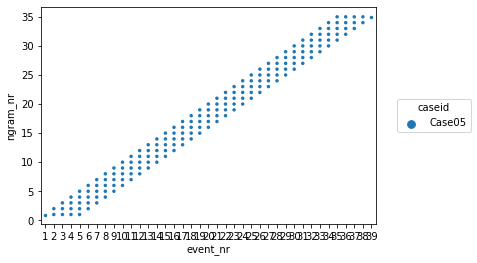

In [26]:
##Checking if the ngrams look as expected
ordered = eg_cases.sort_values(by=['orig_caseid', 'ngram_nr', 'caseid', 'event_nr'], ascending=[True ,True, False, False])
ax = sns.swarmplot(data=ordered ,x='event_nr', y='ngram_nr', hue='orig_caseid', size=3.5)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, title='caseid')
plt.show()

## Task 4

(3 points) Test the results of your modifications with the Turnaround process event log using cluster bucketing, index encoding, and the XGboost model.

_This task is incomplete_

### Divide prefixes into buckets

In [27]:
import BucketFactory #Taken from practice 10 code repository

In [28]:
# encoding_method = "last", "agg", "index"
# Bucketing prefixes based on control flow
bucketer_args = {'encoding_method': 'index', 
                 'case_id_col': 'caseid', 
                 'cat_cols':['activity'], 
                 'num_cols':[], 
                 'random_state':random_state}

In [29]:
cv_iter = 0
dt_test_ngrams = dt_ngrams[cv_iter]
dt_train_ngrams = pd.DataFrame()
for cv_train_iter in range(n_splits): 
    if cv_train_iter != cv_iter:
        dt_train_ngrams = pd.concat([dt_train_ngrams, dt_ngrams[cv_train_iter]], axis=0)

#bucket_methods = "single", "prefix", "state", "cluster", "knn"
bucket_method = 'cluster'
if bucket_method == "cluster":
    bucketer_args["n_clusters"] = 3
bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)
bucket_assignments_train = bucketer.fit_predict(dt_train_ngrams)
bucket_assignments_test = bucketer.predict(dt_test_ngrams)

In [30]:
print('Train assignments:')
bucket_assignments_train
print(pd.DataFrame(bucket_assignments_train, columns=['bucket']).bucket.value_counts())
print('Test assignments:')
bucket_assignments_test
print(pd.DataFrame(bucket_assignments_test, columns=['bucket']).bucket.value_counts())

Train assignments:
0    422
2    276
1    151
Name: bucket, dtype: int64
Test assignments:
0    403
2    311
1    137
Name: bucket, dtype: int64


In [31]:
bucket_number = 2

bucket_indexes = dt_train_ngrams.groupby('caseid').first().index
bucket_indexes = bucket_indexes[bucket_assignments_train == bucket_number]
print(bucket_indexes)
bucket_data = dt_train_ngrams[dt_train_ngrams['caseid'].isin(bucket_indexes)]
bucket_data
def get_label_numeric(data):
    y = data.groupby('caseid').first()['label'] # one row per case
    return [1 if label == 1 else 0 for label in y]
train_y = get_label_numeric(bucket_data)

Index(['Case00-14', 'Case00-15', 'Case00-16', 'Case00-17', 'Case00-18',
       'Case00-19', 'Case00-20', 'Case00-21', 'Case00-22', 'Case00-23',
       ...
       'Case51-13', 'Case51-14', 'Case51-15', 'Case51-16', 'Case51-17',
       'Case51-18', 'Case51-20', 'Case51-21', 'Case51-22', 'Case51-23'],
      dtype='object', name='caseid', length=276)


In [32]:
bucket_indexes = dt_test_ngrams.groupby('caseid').first().index
bucket_indexes = bucket_indexes[bucket_assignments_test == bucket_number]
bucket_data_test = dt_test_ngrams[dt_test_ngrams['caseid'].isin(bucket_indexes)]
bucket_data_test
test_y = get_label_numeric(bucket_data_test)

### Encode prefixes for classification

In [33]:
import EncoderFactory
from sklearn.pipeline import FeatureUnion, Pipeline